In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy
import aubio

In [2]:
loaded_array = np.load('thresholds.npy')
thresholds = loaded_array.tolist()
print(thresholds)
# got the thresholds by visualising the waveform in "threshold.ipynb"

[2.0440150334284857, 200.0, 0.05]


### Three Methods for voiced Unvoiced Detection are:-
 - Energy Threshold
 - Auto-correlation
 - Normalized Linear Prediction error Analysis

In [3]:

def energy(signal):
    energy = np.sum(signal ** 2)
    return energy

def autocorrelation(signal):
    autocorr = np.correlate(signal, signal, mode='full')
    return np.sum(autocorr**2)

def norm_LP_error(signal, o):
    a = librosa.lpc(signal, order=o)
    b = np.hstack([[0], -1 * a[1:]])
    y_hat = scipy.signal.lfilter(b, [1], signal)
    prediction_error = np.var(y_hat - signal)
    signal_power = np.var(signal)
    normalized_error = prediction_error / signal_power
    return normalized_error

def check_energy(signal):
    if(energy(signal)>thresholds[0]):
        return True
    else:
        return False
def check_autocor(signal):
    if(autocorrelation(signal)>thresholds[1]):
        return True
    else:
        return False
def check_error(signal,o):
    if(norm_LP_error(signal, o)<thresholds[0]):
        return True
    else:
        return False


## a) calculate number of frames

In [4]:
def num_frames(y, sr, window_dur,shift_dur):
    i = 0
    frames = []
    t =np.array(range(len(y)))/sr
    # print(len(y),len(t))
    frame_length = int(np.round((sr * window_dur) / 1000))
    shift_length = int(np.round((sr * shift_dur) / 1000))
    times =[]
    while i < len(y):
        frame = y[i:i + frame_length]
        times.append((t[i:i+frame_length]))
        i = i + shift_length
        frames.append(frame)
    return frames,times

In [5]:
audio_file = "../wavs/q4_audio.wav"
y, sr = librosa.load(audio_file)
frames,times = num_frames(y,sr,20,10)
print(len(frames))

65


## b) Plot in waveform and no of frames

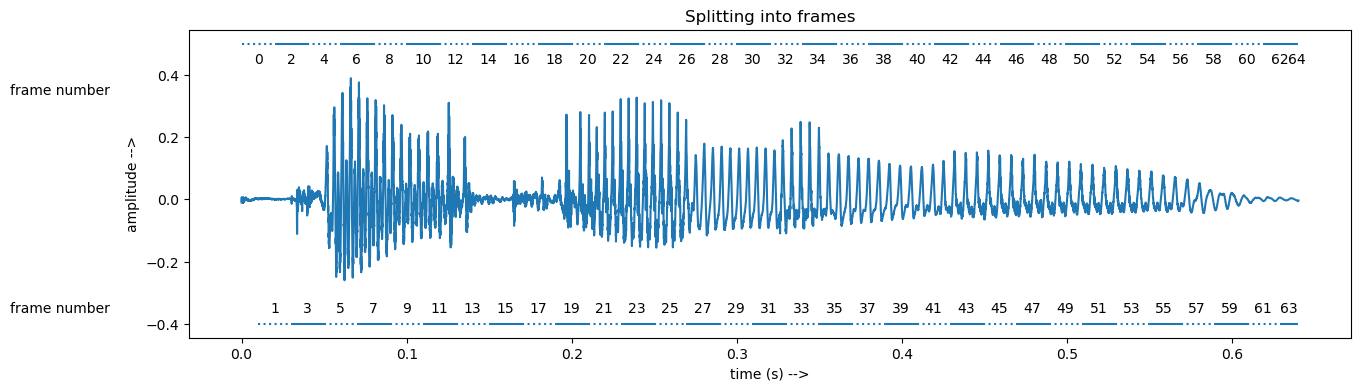

In [6]:
t =np.array(range(len(y)))/sr
fig,ax = plt.subplots(figsize = (15,4))
ax.plot(t,y);
i_even = 0
i_odd = 0
for i in range(len(frames)):
    if( i & 1):
        if(i_even):
            temp = "solid"
        else:
            temp = "dotted"
        ax.hlines(y=[-0.4],xmin = times[i][0],xmax = times[i][-1],linestyles=temp)
        ax.text(x=(times[i][0] + times[i][-1]) / 2, y=-0.4+0.05, s=str(i), ha='center', va='center')
        i_even = not (i_even)
    else:
        if(i_odd):
            temp = "solid"
        else:
            temp = "dotted"
        i_odd = not (i_odd)
        ax.hlines(y=[0.5],xmin = times[i][0],xmax = times[i][-1],linestyles=temp)
        ax.text(x=(times[i][0] + times[i][-1]) / 2, y=0.5-0.05, s=str(i), ha='center', va='center')
ax.text(x = -0.11,y = -0.4+0.05,s=f"frame number",ha = 'center',va ='center');
ax.text(x = -0.11,y = 0.4-0.05,s=f"frame number",ha = 'center',va ='center');
ax.set_xlabel("time (s) -->")
ax.set_ylabel("amplitude -->")
ax.set_title("Splitting into frames");
        

## c) Label each frame as voiced and unvoiced

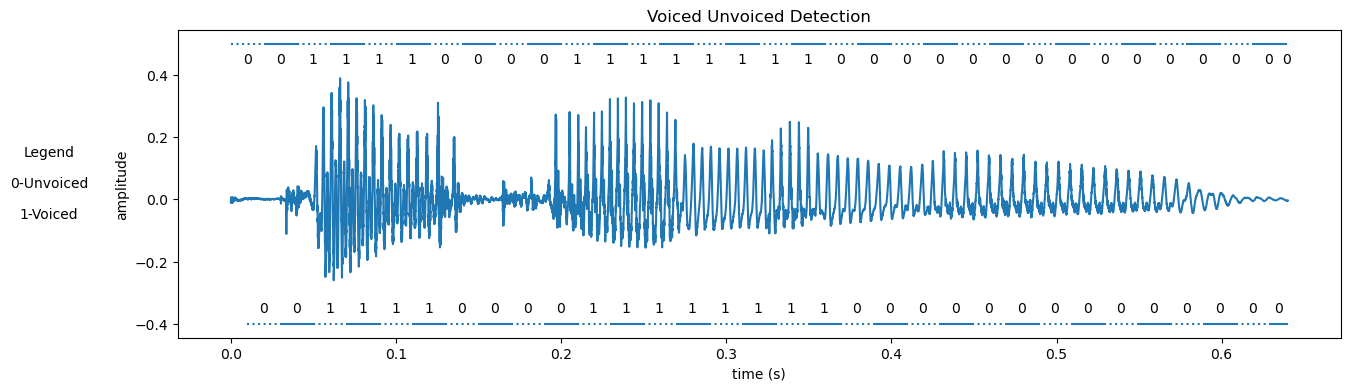

In [7]:
fig,ax = plt.subplots(figsize = (15,4))
ax.plot(t,y);
i_even = 0
i_odd = 0
voiced = []
unvoiced = []
v_uv=[]
for i in range(len(frames)):

    string ="0"
    if( check_energy(frames[i]) and check_autocor(frames[i]) and check_error(frames[i],8) ):
        string = "1"
        v_uv.append(1)
    else:
        v_uv.append(0)

    if(string == "1"):
        voiced.append(frames[i])
    else:
        unvoiced.append(frames[i])
        
    if( i & 1):
        if(i_even):
            temp = "solid"
        else:
            temp = "dotted"
        ax.hlines(y=[-0.4],xmin = times[i][0],xmax = times[i][-1],linestyles=temp)
        ax.text(x=(times[i][0] + times[i][-1]) / 2, y=-0.4+0.05, s=string, ha='center', va='center')
        i_even = not (i_even)
    else:
        if(i_odd):
            temp = "solid"
        else:
            temp = "dotted"
        i_odd = not (i_odd)
        ax.hlines(y=[0.5],xmin = times[i][0],xmax = times[i][-1],linestyles=temp)
        ax.text(x=(times[i][0] + times[i][-1]) / 2, y=0.5-0.05, s=string, ha='center', va='center')
# ax.text(x = -0.15,y = -0.4+0.05,s=f"{names[a]}\nthreshold = {averages[a]}",ha = 'center',va ='center');
ax.text(x = -0.11,y = -0.1+0.05,s=f"1-Voiced",ha = 'center',va ='center');
ax.text(x = -0.11,y = -0.0+0.05,s=f"0-Unvoiced",ha = 'center',va ='center');
ax.text(x = -0.11,y = 0.1+0.05,s=f"Legend",ha = 'center',va ='center');
ax.set_xlabel("time (s)")
ax.set_ylabel("amplitude")
ax.set_title("Voiced Unvoiced Detection");

## d) Fourier Transform

In [8]:
def short_fft(y, sr, window_dur, window_shape, shift_dur):
    i = 0
    short_ffts = []

    frame_length = int(np.round((sr * window_dur) / 1000))
    shift_length = int(np.round((sr * shift_dur) / 1000))

    while i < len(y):
        frame = y[i:i + frame_length]

        if window_shape == 'hann':
            window = np.hanning(frame_length)
        elif window_shape == 'rect':
            window = np.ones(frame_length)
        
        if(len(frame)<frame_length):
            frame = np.concatenate((frame,np.zeros(frame_length-len(frame))),axis=0)
        
        frame = frame * window  # Apply the window function
        fft = np.abs(np.fft.fft(frame))
        short_ffts.append(fft[:(frame_length // 2)+1])

        i = i + shift_length

    short_ffts = np.array(short_ffts).T
    short_ffts = short_ffts / np.max(short_ffts)  # Normalize the FFT
    # magnitude to dB scale
    db_spectrogram = 20 * np.log10((short_ffts+0.0000001))
    
    return db_spectrogram


In [9]:
audio_file = "../wavs/q4_audio.wav"
y, sr = librosa.load(audio_file)
print(len(y),sr)
print(f"dur in ms = {len(y)*1000/sr}")

14112 22050
dur in ms = 640.0


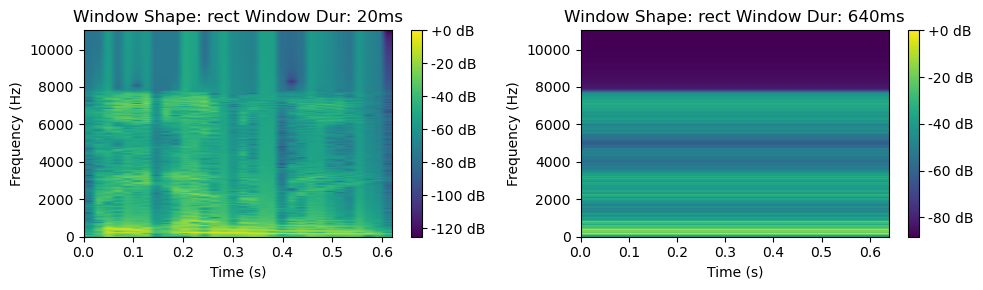

In [10]:
fig, axes = plt.subplots(1, 2,figsize = (10,3))
db_spectrogram = []
time_vector = []
window=[]
dur = 640
for window_dur in [20,dur]:
    shape = 'rect'
    temp = short_fft(y,sr,window_dur,shape,(window_dur))
    db_spectrogram.append(temp)
    num_frames=temp.shape[1]
    if(window_dur == 640):
        time_vector.append([dur/1000])
    else:
        time_vector.append(np.arange(0, num_frames) * (window_dur / 1000.0))
    window.append([shape,window_dur])



for i, ax in enumerate(axes.ravel()):
    im=ax.imshow(db_spectrogram[i], cmap='viridis', origin='lower', aspect='auto', extent=[0, time_vector[i][-1], 0, sr / 2])
    plt.colorbar(im, ax=ax, format="%+2.0f dB")
    ax.set_title(f"Window Shape: {window[i][0]} Window Dur: {window[i][1]}ms")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    
plt.tight_layout()
plt.show()


#### Observations
 - There are some additions high frequency components getting added when you apply fourier transform frame by frame
 - We know the frequencies present in the signal but we do not know which frequencies are present at which time when we apply fourier transform for the entire   signal

## e) Fourier Transform

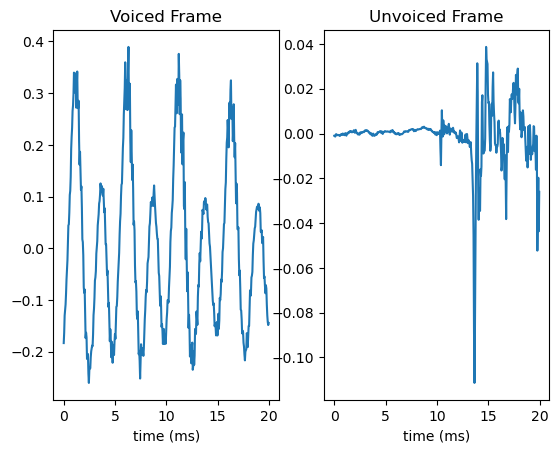

In [11]:
v=voiced[2]
uv=unvoiced[2]
t = (np.array(range(len(v)))/sr)*1000
fig,ax = plt.subplots(1,2)
ax[0].plot(t,v)
ax[0].set_xlabel("time (ms)")
ax[0].set_title("Voiced Frame");
ax[1].plot(t,uv)
ax[1].set_xlabel("time (ms)")
ax[1].set_title("Unvoiced Frame");

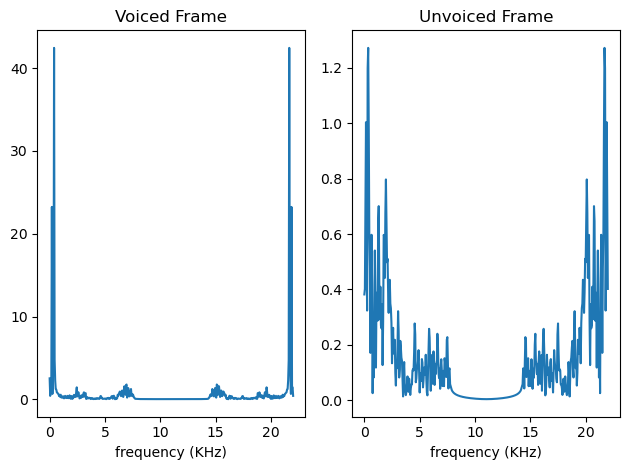

In [12]:

v_f = (np.fft.fft(voiced[2]))
uv_f = (np.fft.fft(unvoiced[2]))
f = np.array(range(len(v)))*sr/(len(v)*1000)
fig,ax = plt.subplots(1,2)
ax[0].plot(f,abs(v_f))
ax[0].set_xlabel("frequency (KHz)")
ax[0].set_title("Voiced Frame")
ax[1].plot(f,abs(uv_f))
ax[1].set_xlabel("frequency (KHz)")
ax[1].set_title("Unvoiced Frame")
plt.tight_layout()

#### Observations in Frequncy Domain
 - Voiced Frame
    - We observe that the peaks are in a harmonic nature with strong components in low frequnecies
 - Unvoiced Frame
    - We observe that the peaks are random and spread throughout the frequency spectrum

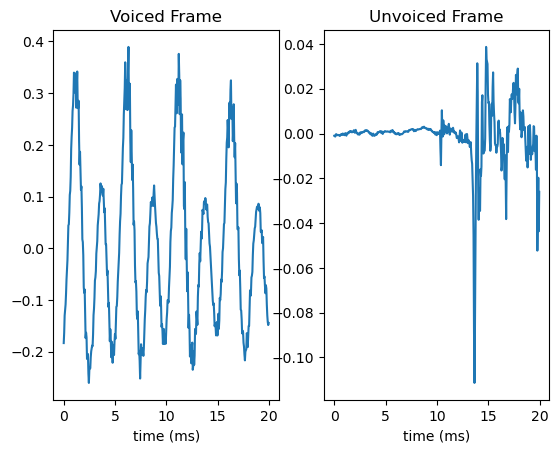

In [22]:
v=np.fft.ifft((v_f), n=len(v_f))
uv=np.fft.ifft((uv_f), n=len(uv_f))
t = (np.array(range(len(v)))/sr)*1000
fig,ax = plt.subplots(1,2)
ax[0].plot(t,v)
ax[0].set_xlabel("time (ms)")
ax[0].set_title("Voiced Frame")
ax[1].plot(t,uv)
ax[1].set_xlabel("time (ms)")
ax[1].set_title("Unvoiced Frame");

#### Observations in Time Domain
 - Voiced Frame
    - We observe that the signal is periodic and has high energy
 - Unvoiced Frame
    - We observe that the signal is random and has low energy.

## f) Pitch Contour

 - We need to Calculate pitch contour frame by frame as pitch is nothing but the fundamental frequency of vocal fold which will be constant only for a very small window of time.
  - Only voiced Frames are considered as there is no pitch in unvoiced frames

In [14]:
def calculate_pitch(frame, sr):
    frame_size = len(frame)
    autocorr = np.correlate(frame, frame, mode='full')
    diff = autocorr[frame_size:] / autocorr[frame_size]  # Normalize
    cumulative_mean_diff = np.cumsum(diff) / (np.arange(1, frame_size) + 1)
    pitch_period = np.argmin(cumulative_mean_diff)
    pitch_frequency = sr / pitch_period
    return pitch_frequency

In [15]:
pitch=[]
for i in range(len(frames)):
    if(v_uv[i]==1):
        pitch.append(calculate_pitch(frames[i],sr))
    else:
        pitch.append(None)

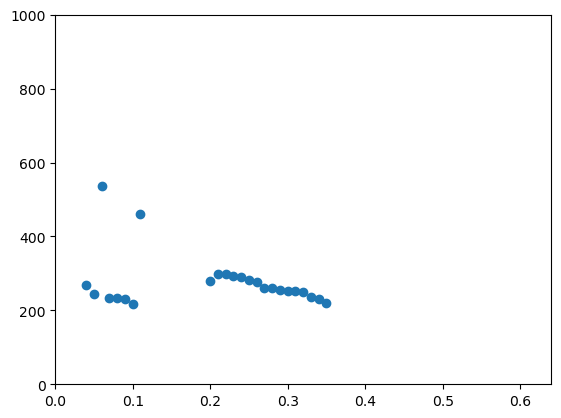

In [16]:
time_vector = (np.arange(0, len(frames)) * (10/ 1000.0))
plt.scatter(time_vector,pitch)
plt.xlim([0.0 , 0.64])
plt.ylim([0 , 1000]);

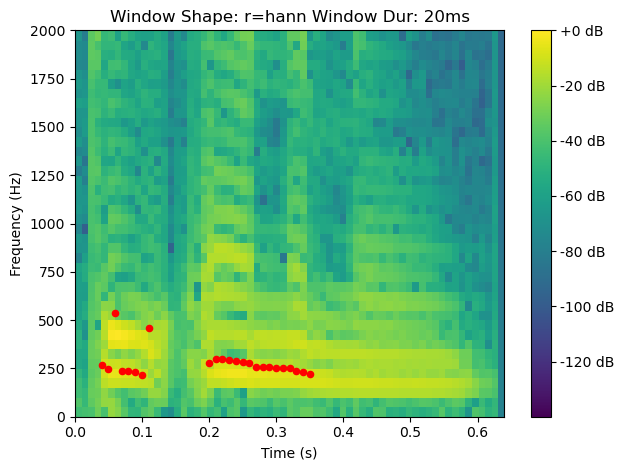

In [17]:
shape = 'hann'
window_dur = 20
temp = short_fft(y,sr,20,shape,10)
db_spectrogram =temp
num_frames=temp.shape[1]
time_vector = (np.arange(0, num_frames) * (window_dur//2 / 1000.0))
fig, ax = plt.subplots()
im=ax.imshow(db_spectrogram, cmap='viridis', origin='lower', aspect='auto', extent=[0, time_vector[-1], 0, sr / 2])
plt.colorbar(im, ax=ax, format="%+2.0f dB")
ax.set_title(f"Window Shape: r=hann Window Dur: {20}ms")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
for i, p in enumerate(pitch):
    if p is not None:
        plt.scatter(time_vector[i], p, c='red', marker='o', s=20, label='Pitch')
ax.set_ylim([0,2000])
plt.tight_layout()
plt.show()